### LSTM 구조
LSTM은 Long Short - Term Memory의 약자이다. 말 그대로 단기 기억을 오래 기억하기 위해 고안되었다. LSTM은 구조가 복잡하므로 단계적으로 설명하겠다. 하지만 기본 개념을 동일하다. LSTM에는 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조를 여러 개 가지고 있다. 이런 계산 결과는 다음 타임스텝에 재사용된다.

먼저 은닉 상태를 만드는 방법을 알아보자. 은닉 상태는 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활설화 함수를 통과시켜 다음 은닉 상태를 만든다. **이때 기본 순환층과는 달리 시그모이드 활성화 함수를 사용한다.** 또 tanh활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 만든다.

LSTM에는 순환되는 상태가 2개이다. 은닉 상태 말고 셀 상태 cell state라고 부르는 값이 또 있다. 은닉 상태와 달리 셀 상태는 다음 층으로 전달되지 않고 LSTM셀에서 순환만 되는 값이다.

***LSTM에는 총 4개의 셀이 있다.***
##### 삭제게이트에 1개, 입력게이트에 2개, 출력게이트에 1개 -> 총 4개

##### p.527-528에 그림과 함께 자세한 설명

### LSTM 신경망 훈련하기
먼저 이전 절에서 처럼 IMDB 리뷰 데이터를 로드하고 훈련 세트와 검증 세트로 나눈다.

In [1]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=500)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

그다음 케라스의 pad_sequences()함수로 각 샘플의 길이를 100에 맞추고 부족할 때는 패딩을 추가한다

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(X_train, maxlen=100)
val_seq = pad_sequences(X_val, maxlen=100)

이제 LSTM 셀을 사용한 순환층을 만들어 보겠다. 사실 SimpleRNN 클래스를 LSTM 클래스로 바꾸기만 하면 된다.

In [3]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

2절에서 임베딩을 사용했던 순환 신경망 모델과 완전히 동일하다. 여기에서는 SimpleRNN 대신 LSTM을 사용한다. 모델 구조를 출력해 보자.

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8809 (34.41 KB)
Trainable params: 8809 (34.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


SimpleRNN 클래스의 모델 파라미터 개수는 200개였다. ***LSTM 셀에는 작은 셀이 4개 있으므로 정확히 4개가 늘어 모델 파라미터 개수는 800개가 되었다.***

모델을 컴파일하고 훈련해 보겠다. 이전과 마찬가지로 배치 크기는 64개, 에포크 횟수는 100으로 지정한다. 체크포인트와 조기 종료를 위한 코드도 동일하다.

In [5]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 4s 10ms/step - loss: 0.6924 - accuracy: 0.5461 - val_loss: 0.6916 - val_accuracy: 0.5714
Epoch 2/100
 19/313 [>.............................] - ETA: 2s - loss: 0.6915 - accuracy: 0.5502

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 3s 9ms/step - loss: 0.6899 - accuracy: 0.6101 - val_loss: 0.6881 - val_accuracy: 0.6286
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6839 - accuracy: 0.6406 - val_loss: 0.6770 - val_accuracy: 0.6334
Epoch 4/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6576 - accuracy: 0.6611 - val_loss: 0.6305 - val_accuracy: 0.7200
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6099 - accuracy: 0.7365 - val_loss: 0.5935 - val_accuracy: 0.7490
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5825 - accuracy: 0.7527 - val_loss: 0.5723 - val_accuracy: 0.7572
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5609 - accuracy: 0.7643 - val_loss: 0.5564 - val_accuracy: 0.7562
Epoch 8/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5402 - accuracy: 0.7757 - val_loss: 0.5419 - val_accuracy: 0.7720
Epoch 9/100

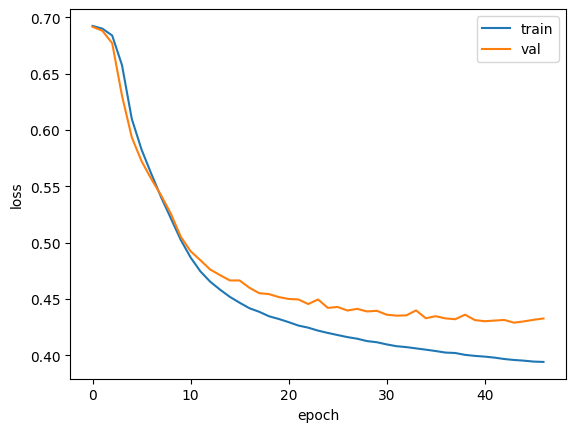

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

그래프를 보면 기본 순환층보다 LSTM이 과대적합을 억제하면서 훈련을 잘 수항한 것으로 보인다. 하지만 경우에 따라서는 과대적합을 더 강하게 제어할 필요가 있다. 7장에서 배웠던 드롭아웃을 순환층에도 적용할 수 있을까? 다음 섹션에서 이에 대해 알아보자.

### 순환층에 드롭아웃 적용하기
완전 연결 신경망과 합성곱 신경망에서는 Dropout 클래스를 사용해 드롭아웃을 적용했다. 이를 통해 모델이 훈련 세트나 너무 과대적합되는 것을 막았다. 순환층은 자체적으로 드롭아웃 기능을 제공한다. SimpleRNN과 LSTM 클래스 모두 dropout 매개변수와 recurrent_dropout 매개변수를 가지고 있다.

dropout 매개변수는 셀의 입력에 드롭아웃을 적용하고 recurrent_dropout은 순환되는 은닉 상태에 드롭아웃을 적용한다. ***하지만 기술적인 문제로 인해 recurrent_dropout을 사용하면 GPU를 사용하여 모델을 훈련하지 못한다.*** 이 대문에 모델의 훈련 속도가 크게 느려진다. 따라서 여기에서는 dropout만을 사용해 보겠다.

전체적인 모델 구조는 이전과 동일하다. LSTM 클래스에 dropout 매개변수를 0.3으로 지정하여 30%의 입력을 드롭아웃 한다.

In [7]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100)) # 두번째 매개변수는 임베딩벡터 크기
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

이 모델을 이전과 동일한 조건으로 훈련해 보자.

In [8]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 4s 10ms/step - loss: 0.6926 - accuracy: 0.5279 - val_loss: 0.6918 - val_accuracy: 0.5782
Epoch 2/100
 19/313 [>.............................] - ETA: 2s - loss: 0.6917 - accuracy: 0.5666

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 3s 10ms/step - loss: 0.6896 - accuracy: 0.6069 - val_loss: 0.6864 - val_accuracy: 0.6296
Epoch 3/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6767 - accuracy: 0.6311 - val_loss: 0.6569 - val_accuracy: 0.6882
Epoch 4/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6364 - accuracy: 0.7102 - val_loss: 0.6181 - val_accuracy: 0.7146
Epoch 5/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6107 - accuracy: 0.7158 - val_loss: 0.5968 - val_accuracy: 0.7310
Epoch 6/100
313/313 [==============================] - 3s 10ms/step - loss: 0.5889 - accuracy: 0.7321 - val_loss: 0.5757 - val_accuracy: 0.7422
Epoch 7/100
313/313 [==============================] - 3s 10ms/step - loss: 0.5677 - accuracy: 0.7430 - val_loss: 0.5577 - val_accuracy: 0.7514
Epoch 8/100
313/313 [==============================] - 3s 10ms/step - loss: 0.5479 - accuracy: 0.7559 - val_loss: 0.5382 - val_accuracy: 0.7630
Epoc

검증 손실이 약간 향상된것 같다. 훈련 손실 그래프를 그려보자.

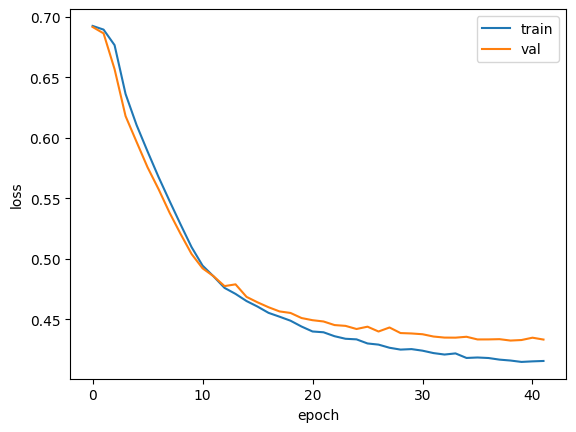

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

LSTM 층에 적용한 드롭아웃이 효과를 발휘한 것 같다. 훈련 손실과 검증 손실 같의 차이가 좁혀진 것을 확인 할수 있었다.

밀집층이나 합성곱 층처럼 순환층도 여러개를 쌓지 않을 이유가 없다. 다음 섹션에서 2개의 순환층을 연결한 모델을 훈련해 보자.



### 2개의 층을 연결하기
순환층을 연결할 때는 한 가지 주의할 점이 있다. 앞서 언급했지만 순환층의 은닉상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달한다. 

하지만 순환층을 쌓게 되면 모든 순환층에 순차데이처가 필요하다. ***따라서 앞쪽의 순환층이 모든 타입스텝에 대한 은닉 상태를 출력해야 한다. 오직 마지막 순환층만 마지막 타임스텝의 은닉 상태를 출력해야 한다.***

케라스의 순환층에서 모든 타임스텝의 은닉 상태를 출력하려면 마지막을 제외한 다른 모든 순환층에서 return_sequences 매개변수를 True로 지정하면 된다. 다음의 코드를 확인해보자.

In [10]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

2개의 LSTM층을 쌓았고 모두 드롭아웃을 0.3으로 지정했다. 그리고 첫 번째 LSTM 클래스에는 return_sequences 매개변수를 True로 지정한 것을 볼 수 있다. summary() 메서드의 결과를 확인해 보자.

In [11]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9353 (36.54 KB)
Trainable params: 9353 (36.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


첫 번째 LSTM 층이 모든 타임스텝(100개)의 은닉 상태를 출력하기 때문에 출력 크기가 (None,100,8)로 표시되었다. 

이에 반해 두 번째 LSTM 층의 출력 크기는 마지막 타임스텝의 은닉 상태만 출력하기 때문에 (None,8)이다.

이 모델을 앞에서와 같이 훈련해 보겠다

In [12]:
rmsprop = keras.optimizers.legacy.RMSprop(learning_rate=1e-4)  
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model3.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 7s 19ms/step - loss: 0.6925 - accuracy: 0.5472 - val_loss: 0.6917 - val_accuracy: 0.6054
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6882 - accuracy: 0.6101 - val_loss: 0.6807 - val_accuracy: 0.6588
Epoch 3/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6460 - accuracy: 0.6741 - val_loss: 0.6065 - val_accuracy: 0.7012
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 0.5884 - accuracy: 0.7090 - val_loss: 0.5637 - val_accuracy: 0.7324
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 0.5553 - accuracy: 0.7387 - val_loss: 0.5438 - val_accuracy: 0.7414
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 0.5331 - accuracy: 0.7516 - val_loss: 0.5199 - val_accuracy: 0.7606
Epoch 7/100
313/313 [==============================] - 6s 18ms/step - loss: 0.5184 - accuracy: 0.7602 - val_loss: 0.5038 - val_accuracy:

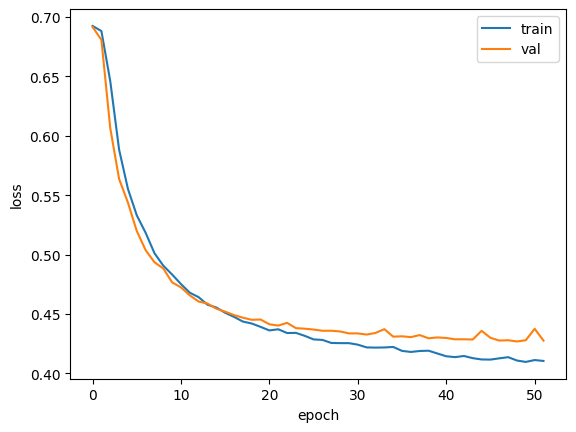

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

그래프를 보면 과대적합을 제어하면서 손실을 최대한 낮춘 것 같다. 지금까지 LSTM 셀을 사용한 훈련과 드롭아웃을 적용해 보았고 2개의 층을 쌓은 순환 신경망을 만들어보았다.

### GRU 구조
GTU 는 Gated Recurrent Unit의 약자이다. 뉴욕 대학교 조경현 교수가 발명한 셀로 유명하다. 이 셀은 LSTM을 간소화한 버전으로 생각할 수 있다.

이셀은 LSTM 처럼 셀 상태를 계산하지 않고 은닉 상태 하나만 포함하고 있다.

GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어있다. 2개는 시그모이드 활성화 함수를 사용하고 하나는 tanh 활성화 함수를 사용한다.

GRU 셀은 LSTM보다 가중치가 적기 떄문에 계산량이 적지만 LSTM 못지 않은 좋은 성능을 내는 것으로 알려져있다.

### GRU 신경망 훈련하기

In [15]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM 클래스를 GRU 클래스로 바뀐 것 외에는 이전 모델과 동일하다. 이 모델의 구조를 확인해 보자.

In [16]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8633 (33.72 KB)
Trainable params: 8633 (33.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


GRU 층의 모델 파라미터 개수를 계산해 보겠다. GRU 셀에는 3개의 작은 셀이 있다. 작은 셀에는 입력과 은닉 상태에 곱하는 가중치와 절편이 있다. 입력에 곱하는 가중치는 16 x 8 = 128개 이고 은닉 상태에 곱하는 가중치는 8 x 8 = 64개이다. 그리고 절편은 뉴런마다 하나씩이므로 8개이다. 모두 더하면 128 + 64 + 8 = 200개 이다. 

이런 작은 셀이 3개이므로 모두 600개의 모델 파라미터가 필요하다. 그런데 summary()메서드의 출력은 624개이다. 무엇이 잘못 되었을까?



사실 텐서플로에 기본적으로 구현된 GRU 셀의 계산은 앞의 그림과 조금 다르다. GRU 셀의 초기 버전은 다음 그림과 같이 계산된다.
(p.540)

##### 작은 셀마다 하나씩 절편이 추가되고 8개의 뉴런이 있으므로 총 24개의 모델 파라미터가 더해진다. 따라서 GRU층의 총 모델 파라미터 개수는 624개가 된다.

텐서플로가 이런 계산 방식을 사용하는 이유는 GPU를 잘 활용하기 위해서이다. GRU셀을 사용한 순환 신경망을 훈련해 보자. 역시 훈련 방법은 이전과 동일하다.

In [17]:
rmsprop = keras.optimizers.legacy.RMSprop(learning_rate=1e-4)  
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model4.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 4s 11ms/step - loss: 0.6925 - accuracy: 0.5270 - val_loss: 0.6917 - val_accuracy: 0.5480
Epoch 2/100
 19/313 [>.............................] - ETA: 2s - loss: 0.6924 - accuracy: 0.5214

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 3s 10ms/step - loss: 0.6908 - accuracy: 0.5623 - val_loss: 0.6898 - val_accuracy: 0.5924
Epoch 3/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6877 - accuracy: 0.6055 - val_loss: 0.6860 - val_accuracy: 0.6172
Epoch 4/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6818 - accuracy: 0.6285 - val_loss: 0.6786 - val_accuracy: 0.6326
Epoch 5/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6702 - accuracy: 0.6465 - val_loss: 0.6637 - val_accuracy: 0.6434
Epoch 6/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6457 - accuracy: 0.6641 - val_loss: 0.6297 - val_accuracy: 0.6714
Epoch 7/100
313/313 [==============================] - 3s 10ms/step - loss: 0.5920 - accuracy: 0.7023 - val_loss: 0.5724 - val_accuracy: 0.7224
Epoch 8/100
313/313 [==============================] - 3s 10ms/step - loss: 0.5507 - accuracy: 0.7347 - val_loss: 0.5496 - val_accuracy: 0.7362
Epoc

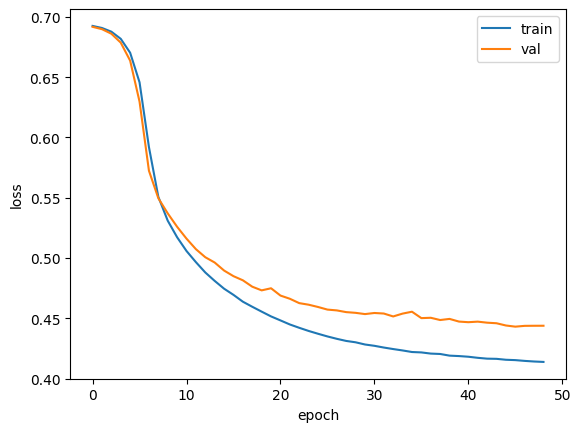

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

드롭아웃을 사용하지 않았기 때문에 이전보다 훈련 손실 차이가 있지만 훈련 과정이 잘 수렴되고 있는 것을 확인할 수 있다. 순환 신경망에서 가장 인기 있는 LSTM와 GRU셀을 사용해 성공적으로 훈련 시켰다.

댓글을 긍정과 부정으로 분류할 수 있다!